In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [2]:
selected_cell = 'LSEC'

In [3]:
estimation = pd.read_csv('TCGA-LIHC.Endothelium.csv',index_col=0)
estimation.head()

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE
Mixture,,,,,,,,,
TCGA-FV-A495-01,0.029261,0.321348,0.048555,0.223134,0.115910,0.261792,0,0.856237,0.598103
TCGA-G3-A3CH-11,0.000000,0.242231,0.110265,0.363060,0.107582,0.176862,0,0.923377,0.393501
TCGA-CC-A3MB-01,0.088565,0.155909,0.068922,0.086031,0.073978,0.526595,0,0.762892,0.828435
TCGA-BC-A3KF-01,0.000000,0.400355,0.077137,0.132735,0.092583,0.297190,0,0.802159,0.743401
TCGA-DD-A4NV-01,0.000000,0.184242,0.058940,0.261421,0.250689,0.244708,0,0.817326,0.604757


In [4]:
sample_list = [sample for sample in estimation.index.values if '-01' in sample]
estimation = estimation.reindex(sample_list)

In [5]:
survival_data = pd.read_csv('survival_LIHC_survival.txt',index_col=0,delimiter='\t')
sample_list = [sample for sample in survival_data.index.values if '-01' in sample]
survival_data = survival_data.reindex(sample_list)
survival_data.head()

,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
sample,,,,,,,,,,
TCGA-2V-A95S-01,TCGA-2V-A95S,0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
TCGA-2Y-A9GS-01,TCGA-2Y-A9GS,1,724.0,1.0,724.0,1.0,102.0,1,102.0,NaN
TCGA-2Y-A9GT-01,TCGA-2Y-A9GT,1,1624.0,1.0,1624.0,1.0,1083.0,1,1083.0,NaN
TCGA-2Y-A9GU-01,TCGA-2Y-A9GU,0,1939.0,0.0,1939.0,0.0,1939.0,0,1939.0,NaN
TCGA-2Y-A9GV-01,TCGA-2Y-A9GV,1,2532.0,1.0,2532.0,0.0,2532.0,1,1745.0,NaN


In [6]:
dfs_data = survival_data.filter(['DFI.time', 'DFI'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFI']]
dfs_data['DFS_T'] = [time/30 for time in dfs_data['DFI.time']]
dfs_data.head()

,DFI.time,DFI,DFS_E,DFS_T
sample,,,,
TCGA-2Y-A9GS-01,102.0,1.0,True,3.400000
TCGA-2Y-A9GT-01,1083.0,1.0,True,36.100000
TCGA-2Y-A9GU-01,1939.0,0.0,False,64.633333
TCGA-2Y-A9GV-01,2532.0,0.0,False,84.400000
TCGA-2Y-A9GW-01,1229.0,1.0,True,40.966667


In [7]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE,DFI.time,DFI,DFS_E,DFS_T
TCGA-FV-A495-01,0.029261,0.321348,0.048555,0.223134,0.115910,0.261792,0,0.856237,0.598103,1.0,0.0,False,0.033333
TCGA-CC-A3MB-01,0.088565,0.155909,0.068922,0.086031,0.073978,0.526595,0,0.762892,0.828435,315.0,0.0,False,10.500000
TCGA-BC-A3KF-01,0.000000,0.400355,0.077137,0.132735,0.092583,0.297190,0,0.802159,0.743401,8.0,0.0,False,0.266667
TCGA-DD-A4NV-01,0.000000,0.184242,0.058940,0.261421,0.250689,0.244708,0,0.817326,0.604757,2398.0,0.0,False,79.933333
TCGA-BD-A3EP-01,0.037617,0.427776,0.046446,0.096096,0.119377,0.272687,0,0.753843,0.807542,409.0,0.0,False,13.633333


In [8]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE,DFI.time,DFI,DFS_E,DFS_T
TCGA-LG-A9QC-01,0.0,0.202855,0.139654,0.161309,0.184158,0.312025,0,0.551786,0.846056,425.0,0.0,False,14.166667
TCGA-RC-A7S9-01,0.0,0.098403,0.108375,0.184166,0.109632,0.499424,0,0.688425,0.760040,640.0,0.0,False,21.333333
TCGA-DD-A1EE-01,0.0,0.267214,0.103202,0.085050,0.113748,0.430785,0,0.673945,0.852649,44.0,1.0,True,1.466667
TCGA-G3-A5SK-01,0.0,0.144742,0.103114,0.357720,0.148556,0.245868,0,0.853461,0.526171,483.0,1.0,True,16.100000
TCGA-K7-A5RF-01,0.0,0.218596,0.101738,0.315495,0.136989,0.227182,0,0.897239,0.464051,205.0,1.0,True,6.833333


In [9]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [10]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
optimization

10

In [11]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.0897755345439057

In [12]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.00962

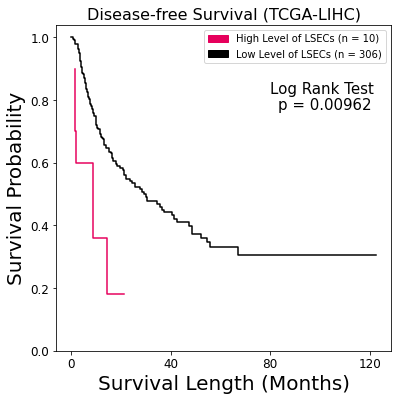

In [13]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,121,40),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of LSECs (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of LSECs (n = %s)'%len(E_low))
plt.text(80,0.82, 'Log Rank Test',fontsize=15)
plt.text(83,0.77, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=10)
plt.title('Disease-free Survival (TCGA-LIHC)',fontsize=16)
plt.savefig('TCGA-LIHC.%s.DFS.pdf'%selected_cell,format='pdf')

In [14]:
os_data = survival_data.filter(['OS.time', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS']]
os_data['OS_T'] = [time/30 for time in os_data['OS.time']]
os_data.head()

,OS.time,OS,OS_E,OS_T
sample,,,,
TCGA-2Y-A9GS-01,724.0,1,True,24.133333
TCGA-2Y-A9GT-01,1624.0,1,True,54.133333
TCGA-2Y-A9GU-01,1939.0,0,False,64.633333
TCGA-2Y-A9GV-01,2532.0,1,True,84.400000
TCGA-2Y-A9GW-01,1271.0,1,True,42.366667


In [15]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE,OS.time,OS,OS_E,OS_T
TCGA-FV-A495-01,0.029261,0.321348,0.048555,0.223134,0.115910,0.261792,0,0.856237,0.598103,1.0,0,False,0.033333
TCGA-CC-A3MB-01,0.088565,0.155909,0.068922,0.086031,0.073978,0.526595,0,0.762892,0.828435,315.0,1,True,10.500000
TCGA-BC-A3KF-01,0.000000,0.400355,0.077137,0.132735,0.092583,0.297190,0,0.802159,0.743401,8.0,0,False,0.266667
TCGA-DD-A4NV-01,0.000000,0.184242,0.058940,0.261421,0.250689,0.244708,0,0.817326,0.604757,2398.0,0,False,79.933333
TCGA-CC-A1HT-01,0.044137,0.445313,0.006798,0.001061,0.185631,0.317060,0,0.699909,0.897641,101.0,1,True,3.366667


In [16]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,LVECt,Other,LSEC,Hepatocytes,LVEC,Carcinoma,P-value,Correlation,RMSE,OS.time,OS,OS_E,OS_T
TCGA-LG-A9QC-01,0.000000,0.202855,0.139654,0.161309,0.184158,0.312025,0,0.551786,0.846056,425.0,0,False,14.166667
TCGA-RC-A7S9-01,0.000000,0.098403,0.108375,0.184166,0.109632,0.499424,0,0.688425,0.760040,640.0,0,False,21.333333
TCGA-DD-A1EE-01,0.000000,0.267214,0.103202,0.085050,0.113748,0.430785,0,0.673945,0.852649,349.0,1,True,11.633333
TCGA-G3-A5SK-01,0.000000,0.144742,0.103114,0.357720,0.148556,0.245868,0,0.853461,0.526171,744.0,0,False,24.800000
TCGA-K7-A5RF-01,0.000000,0.218596,0.101738,0.315495,0.136989,0.227182,0,0.897239,0.464051,631.0,0,False,21.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ED-A5KG-01,0.169362,0.455125,0.000000,0.021241,0.096246,0.258026,0,0.658028,0.896492,854.0,0,False,28.466667
TCGA-DD-AA3A-01,0.043879,0.167927,0.000000,0.001584,0.185401,0.601209,0,0.735344,0.917424,410.0,1,True,13.666667
TCGA-CC-5260-01,0.026891,0.204416,0.000000,0.000000,0.181703,0.586991,0,0.594033,0.933624,87.0,1,True,2.900000
TCGA-ED-A82E-01,0.008099,0.127732,0.000000,0.000000,0.212477,0.651692,0,0.526679,0.944634,408.0,0,False,13.600000


In [ ]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [ ]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
optimization

In [ ]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

In [ ]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

In [ ]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,121,40),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of LSECs (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of LSECs (n = %s)'%len(E_low))
plt.text(80,0.82, 'Log Rank Test',fontsize=15)
plt.text(83,0.76, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=10)
plt.title('Overall Survival (TCGA-LIHC)',fontsize=16)
plt.savefig('TCGA-LIHC.%s.OS.pdf'%selected_cell,format='pdf')

In [ ]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.xlabel('TCGA-LIHC Cohort',fontsize=15)
plt.title('Cutting Point - LSECs',fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
#plt.yscale("log")
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')